In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import scipy.io as sio
from keras.layers import Conv3D, AveragePooling3D
from keras.layers.normalization import BatchNormalization
from keras.callbacks  import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, auc
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks  import EarlyStopping
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
dataPath = '../data/spectral_feat_tensor_full_with_full_labels_images_3dcnn_norm.mat'
savePath = '../results/CNN_3D_our/'

experiment = 'MultiClass_PD'

filename = savePath+'CNN_3D_results_'+experiment+'.mat'
plot_title = 'Categorical Emotion Classification - PD'

nb_filters = [16, 32, 32, 64, 128]
kernel_size = 3
pool_size = 2
stride_size = 2
padding = 'same'
weight_decay = 0.000001
dense_layer_neuron_num = 128
epochs = 50
momentum = 0.8

matContent = sio.loadmat(dataPath)
features = matContent['pd_feat_img']
print("features shape:", features.shape)
labels = np.squeeze(matContent['pd_multi_labels'])
labels[labels < 0] = 0
features = np.swapaxes(features,2,4)
features = np.swapaxes(features,2,3)
labels[labels == 6] = 0
#labels = labels.astype(int)

#df = pd.read_csv(dataPath, header = None)
#features = df.iloc[1:,:-2].to_numpy()
#labels = df.iloc[1:,-1].to_numpy() # last but one column for PD vs NC

#dict_hvlv = {1:0, 2:1, 3:0, 4:0, 5:1, 6:0} #HVLV labels mapping dictionary
#labels = labels.map(dict_hvlv).to_numpy()
#labels[labels == 1] = 0
#labels[labels == 2] = 1
#labels[labels == 3] = 1
#labels[labels == 4] = 1
#labels[labels == 5] = 1
#labels[labels == 6] = 1
#labels[labels < 0]=0
#labels[labels == 6]=0

# randomise the sample sequence
rand_order = np.arange(features.shape[0])
np.random.shuffle(rand_order)
features = features[rand_order,]
labels = np.squeeze(labels[rand_order,])
class_num = np.size(np.unique(labels))
labels_categorical = np_utils.to_categorical(labels, class_num)
del matContent

print('Features shape:', features.shape)
print('Number of classes:', class_num)
print('Unique labels:', np.unique(labels))

features shape: (7388, 5, 3, 32, 32)
Features shape: (7388, 5, 32, 32, 3)
Number of classes: 6
Unique labels: [0 1 2 3 4 5]


In [3]:
def create_model(init_mode, activation, dropout_rate, optimizer, learn_rate):
#def create_model(activation):
  model = Sequential()
  model.add(Conv3D(filters=nb_filters[0], kernel_size=kernel_size, padding=padding,
                   activation=activation, input_shape=(features.shape[1], features.shape[2],
                                                       features.shape[3], features.shape[4]), trainable=True))
  model.add(AveragePooling3D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv3D(filters=nb_filters[1], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling3D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv3D(filters=nb_filters[2], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling3D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  #model.add(Conv1D(filters=nb_filters[3], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  #model.add(Conv1D(filters=nb_filters[4], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  model.add(Flatten())
  model.add(BatchNormalization(epsilon=0.001))
  model.add(Dense(dense_layer_neuron_num, kernel_initializer=init_mode, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(class_num))
  model.add(Activation('softmax'))
  #model.summary()
  #model.load_weights('Gender_notClean_HIweights.hdf5')
  #earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
  if optimizer == 'SGD':
    opt = SGD(learning_rate=learn_rate / 10 ** epochs, momentum = momentum, decay = weight_decay, nesterov = True)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'Adam':
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'RMSprop':
    opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


In [ ]:
cnn_model = KerasClassifier(build_fn=create_model, verbose=1)

#batch_size = [16,32]
#epochs = [5,10,15]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'he_normal', 'he_uniform']
#activation = ['softmax', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#neurons = [1, 5, 10, 15, 20, 25, 30]

learn_rate = [0.001, 0.01, 0.1]
optimizer = ['SGD', 'Adam','RMSprop']
#momentum = [0.8,0.9]
init_mode = ['he_normal','he_uniform']
activation = ['relu','tanh']
dropout_rate = [0.3,0.4,0.5]
foldNum = 10

p_grid = dict(init_mode=init_mode, dropout_rate=dropout_rate, activation=activation,
              optimizer=optimizer, learn_rate=learn_rate)
              #, momentum=momentum)
grid = GridSearchCV(estimator=cnn_model, param_grid=p_grid,
                    cv=foldNum, verbose=0)
# Standerdize
#feat_shape = features.shape
#features = np.reshape(features, (feat_shape[0], feat_shape[1]*feat_shape[2]))
#scaler = StandardScaler()
#scaler.fit(features)
#scaleFeatures = scaler.transform(features)
#scaleFeatures = np.reshape(scaleFeatures, (features.shape[0], 6, -1))

print('Performing Gridsearch')
grid_result = grid.fit(features,labels_categorical)
best_params = grid_result.best_params_
print('Best parameters:', best_params)
tf.keras.backend.clear_session()
estimator = create_model(init_mode=best_params.get('init_mode'), learn_rate=best_params.get('learn_rate'), 
                         optimizer=best_params.get('optimizer'), activation=best_params.get('activation'), 
                         dropout_rate=best_params.get('dropout_rate'))

In [4]:
mat_path = '../results/CNN_3D_our/CNN_3D_results_MultiClass_PD.mat'
params = sio.loadmat(mat_path)
best_params = params['best_params']
del mat_path
print(best_params)

[[(array(['tanh'], dtype='<U4'), array([[0.3]]), array(['he_uniform'], dtype='<U10'), array([[0.01]]), array(['Adam'], dtype='<U4'))]]


In [5]:
tf.keras.backend.clear_session()
estimator = create_model(init_mode='he_normal', learn_rate=0.01, optimizer='Adam', activation='tanh', 
                         dropout_rate=0.3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 5, 32, 32, 16)     1312      
_________________________________________________________________
average_pooling3d (AveragePo (None, 3, 16, 16, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 16, 16, 32)     13856     
_________________________________________________________________
average_pooling3d_1 (Average (None, 2, 8, 8, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 8, 8, 32)       27680     
_________________________________________________________________
average_pooling3d_2 (Average (None, 1, 4, 4, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

/home/soujanya/anaconda3/envs/eegenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/soujanya/anaconda3/envs/eegenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


MultiClass_PD_CNN: Fold 1 : f1_macroscore: 0.6746
MultiClass_PD_CNN: Fold 1 : f1_weightedscore: 0.6744
MultiClass_PD_CNN: Fold 1 : acc: 0.6739
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 5, 32, 32, 16)     1312      
_________________________________________________________________
average_pooling3d (AveragePo (None, 3, 16, 16, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 16, 16, 32)     13856     
_________________________________________________________________
average_pooling3d_1 (Average (None, 2, 8, 8, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 8, 8, 32)       27680     
_________________________________________________________________
average_pooling3d_2 (Average (None, 1, 4, 4, 

Epoch 1/50
187/187 - 1s - loss: 0.3743 - accuracy: 0.8728 - val_loss: 1.1044 - val_accuracy: 0.6707
Epoch 2/50
187/187 - 1s - loss: 0.3504 - accuracy: 0.8822 - val_loss: 1.0645 - val_accuracy: 0.6857
Epoch 3/50
187/187 - 1s - loss: 0.3447 - accuracy: 0.8790 - val_loss: 1.0112 - val_accuracy: 0.6692
Epoch 4/50
187/187 - 1s - loss: 0.3135 - accuracy: 0.8919 - val_loss: 1.0499 - val_accuracy: 0.7068
Epoch 5/50
187/187 - 1s - loss: 0.3029 - accuracy: 0.8982 - val_loss: 1.0214 - val_accuracy: 0.6947
Epoch 6/50
187/187 - 1s - loss: 0.3061 - accuracy: 0.8946 - val_loss: 1.1482 - val_accuracy: 0.6737
Epoch 7/50
187/187 - 1s - loss: 0.2947 - accuracy: 0.8942 - val_loss: 1.0489 - val_accuracy: 0.6932
Epoch 8/50
187/187 - 1s - loss: 0.2923 - accuracy: 0.8969 - val_loss: 1.0274 - val_accuracy: 0.7008
Epoch 9/50
187/187 - 1s - loss: 0.3067 - accuracy: 0.8890 - val_loss: 1.0522 - val_accuracy: 0.6812
Epoch 10/50
187/187 - 1s - loss: 0.2920 - accuracy: 0.8972 - val_loss: 1.0210 - val_accuracy: 0.7008

Epoch 12/50
187/187 - 1s - loss: 0.2029 - accuracy: 0.9293 - val_loss: 1.3276 - val_accuracy: 0.6692
Epoch 13/50
187/187 - 1s - loss: 0.2178 - accuracy: 0.9250 - val_loss: 1.2212 - val_accuracy: 0.6797
Epoch 14/50
187/187 - 1s - loss: 0.1965 - accuracy: 0.9362 - val_loss: 1.1919 - val_accuracy: 0.7068
Epoch 15/50
187/187 - 1s - loss: 0.1881 - accuracy: 0.9395 - val_loss: 1.1913 - val_accuracy: 0.6872
Epoch 16/50
187/187 - 1s - loss: 0.1962 - accuracy: 0.9337 - val_loss: 1.2398 - val_accuracy: 0.6827
Epoch 17/50
187/187 - 1s - loss: 0.2012 - accuracy: 0.9353 - val_loss: 1.2577 - val_accuracy: 0.6692
Epoch 18/50
187/187 - 1s - loss: 0.2086 - accuracy: 0.9268 - val_loss: 1.2589 - val_accuracy: 0.6767
Epoch 19/50
187/187 - 1s - loss: 0.1836 - accuracy: 0.9380 - val_loss: 1.2334 - val_accuracy: 0.6962
Epoch 20/50
187/187 - 1s - loss: 0.1918 - accuracy: 0.9360 - val_loss: 1.2992 - val_accuracy: 0.6812
Epoch 21/50
187/187 - 1s - loss: 0.1963 - accuracy: 0.9350 - val_loss: 1.1964 - val_accurac

Epoch 23/50
187/187 - 1s - loss: 0.1800 - accuracy: 0.9418 - val_loss: 1.3209 - val_accuracy: 0.6947
Epoch 24/50
187/187 - 1s - loss: 0.1655 - accuracy: 0.9472 - val_loss: 1.2936 - val_accuracy: 0.6932
Epoch 25/50
187/187 - 1s - loss: 0.1557 - accuracy: 0.9469 - val_loss: 1.3568 - val_accuracy: 0.6797
Epoch 26/50
187/187 - 1s - loss: 0.1628 - accuracy: 0.9465 - val_loss: 1.2751 - val_accuracy: 0.7068
Epoch 27/50
187/187 - 1s - loss: 0.1595 - accuracy: 0.9467 - val_loss: 1.2984 - val_accuracy: 0.6677
Epoch 28/50
187/187 - 1s - loss: 0.1561 - accuracy: 0.9454 - val_loss: 1.2843 - val_accuracy: 0.6992
Epoch 29/50
187/187 - 1s - loss: 0.1638 - accuracy: 0.9439 - val_loss: 1.3031 - val_accuracy: 0.7008
Epoch 30/50
187/187 - 1s - loss: 0.1492 - accuracy: 0.9477 - val_loss: 1.3348 - val_accuracy: 0.6947
Epoch 31/50
187/187 - 1s - loss: 0.1499 - accuracy: 0.9489 - val_loss: 1.2691 - val_accuracy: 0.6887
Epoch 32/50
187/187 - 1s - loss: 0.1494 - accuracy: 0.9517 - val_loss: 1.2401 - val_accurac

Epoch 34/50
187/187 - 1s - loss: 0.1224 - accuracy: 0.9555 - val_loss: 1.4425 - val_accuracy: 0.6857
Epoch 35/50
187/187 - 1s - loss: 0.1221 - accuracy: 0.9584 - val_loss: 1.4717 - val_accuracy: 0.6947
Epoch 36/50
187/187 - 1s - loss: 0.1271 - accuracy: 0.9589 - val_loss: 1.3899 - val_accuracy: 0.7053
Epoch 37/50
187/187 - 1s - loss: 0.1228 - accuracy: 0.9579 - val_loss: 1.3469 - val_accuracy: 0.6962
Epoch 38/50
187/187 - 1s - loss: 0.1309 - accuracy: 0.9559 - val_loss: 1.4576 - val_accuracy: 0.6812
Epoch 39/50
187/187 - 1s - loss: 0.1111 - accuracy: 0.9611 - val_loss: 1.4026 - val_accuracy: 0.6722
Epoch 40/50
187/187 - 1s - loss: 0.1252 - accuracy: 0.9572 - val_loss: 1.4646 - val_accuracy: 0.7068
Epoch 41/50
187/187 - 1s - loss: 0.1490 - accuracy: 0.9510 - val_loss: 1.3960 - val_accuracy: 0.6812
Epoch 42/50
187/187 - 1s - loss: 0.1400 - accuracy: 0.9499 - val_loss: 1.4041 - val_accuracy: 0.6917
Epoch 43/50
187/187 - 1s - loss: 0.1254 - accuracy: 0.9552 - val_loss: 1.5032 - val_accurac

Epoch 45/50
187/187 - 1s - loss: 0.1128 - accuracy: 0.9621 - val_loss: 1.5214 - val_accuracy: 0.7053
Epoch 46/50
187/187 - 1s - loss: 0.1144 - accuracy: 0.9611 - val_loss: 1.5145 - val_accuracy: 0.6752
Epoch 47/50
187/187 - 1s - loss: 0.1159 - accuracy: 0.9631 - val_loss: 1.5847 - val_accuracy: 0.6737
Epoch 48/50
187/187 - 1s - loss: 0.1323 - accuracy: 0.9559 - val_loss: 1.6166 - val_accuracy: 0.6752
Epoch 49/50
187/187 - 1s - loss: 0.1297 - accuracy: 0.9545 - val_loss: 1.5561 - val_accuracy: 0.6827
Epoch 50/50
187/187 - 1s - loss: 0.1074 - accuracy: 0.9647 - val_loss: 1.4642 - val_accuracy: 0.6917
MultiClass_PD_CNN: Fold 7 : f1_macroscore: 0.9448
MultiClass_PD_CNN: Fold 7 : f1_weightedscore: 0.9447
MultiClass_PD_CNN: Fold 7 : acc: 0.9445
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 5, 32, 32, 16)     1312      
_________________________________

Epoch 1/50
188/188 - 7s - loss: 0.1109 - accuracy: 0.9649 - val_loss: 1.6093 - val_accuracy: 0.6722
Epoch 2/50
188/188 - 2s - loss: 0.1479 - accuracy: 0.9497 - val_loss: 1.5190 - val_accuracy: 0.6722
Epoch 3/50
188/188 - 2s - loss: 0.1243 - accuracy: 0.9584 - val_loss: 1.5562 - val_accuracy: 0.6827
Epoch 4/50
188/188 - 2s - loss: 0.1202 - accuracy: 0.9569 - val_loss: 1.5719 - val_accuracy: 0.6707
Epoch 5/50
188/188 - 2s - loss: 0.1125 - accuracy: 0.9616 - val_loss: 1.5464 - val_accuracy: 0.6857
Epoch 6/50
188/188 - 2s - loss: 0.1028 - accuracy: 0.9634 - val_loss: 1.4738 - val_accuracy: 0.6827
Epoch 7/50
188/188 - 2s - loss: 0.1096 - accuracy: 0.9621 - val_loss: 1.5140 - val_accuracy: 0.7008
Epoch 8/50
188/188 - 2s - loss: 0.1122 - accuracy: 0.9617 - val_loss: 1.6718 - val_accuracy: 0.6692
Epoch 9/50
188/188 - 2s - loss: 0.1091 - accuracy: 0.9646 - val_loss: 1.5948 - val_accuracy: 0.6737
Epoch 10/50
188/188 - 2s - loss: 0.1013 - accuracy: 0.9647 - val_loss: 1.5785 - val_accuracy: 0.6767

Epoch 12/50
188/188 - 2s - loss: 0.0951 - accuracy: 0.9681 - val_loss: 1.5602 - val_accuracy: 0.6872
Epoch 13/50
188/188 - 2s - loss: 0.0987 - accuracy: 0.9657 - val_loss: 1.6418 - val_accuracy: 0.6722
Epoch 14/50
188/188 - 2s - loss: 0.0917 - accuracy: 0.9696 - val_loss: 1.5945 - val_accuracy: 0.6827
Epoch 15/50
188/188 - 2s - loss: 0.0892 - accuracy: 0.9699 - val_loss: 1.5385 - val_accuracy: 0.6887
Epoch 16/50
188/188 - 2s - loss: 0.0878 - accuracy: 0.9721 - val_loss: 1.6123 - val_accuracy: 0.6797
Epoch 17/50
188/188 - 2s - loss: 0.1072 - accuracy: 0.9629 - val_loss: 1.6171 - val_accuracy: 0.6797
Epoch 18/50
188/188 - 2s - loss: 0.0907 - accuracy: 0.9694 - val_loss: 1.6175 - val_accuracy: 0.6962
Epoch 19/50
188/188 - 2s - loss: 0.0932 - accuracy: 0.9681 - val_loss: 1.5758 - val_accuracy: 0.6947
Epoch 20/50
188/188 - 2s - loss: 0.0792 - accuracy: 0.9744 - val_loss: 1.6569 - val_accuracy: 0.6707
Epoch 21/50
188/188 - 2s - loss: 0.0919 - accuracy: 0.9713 - val_loss: 1.5626 - val_accurac

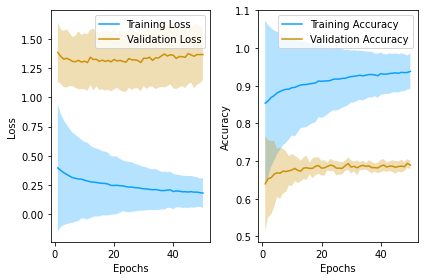

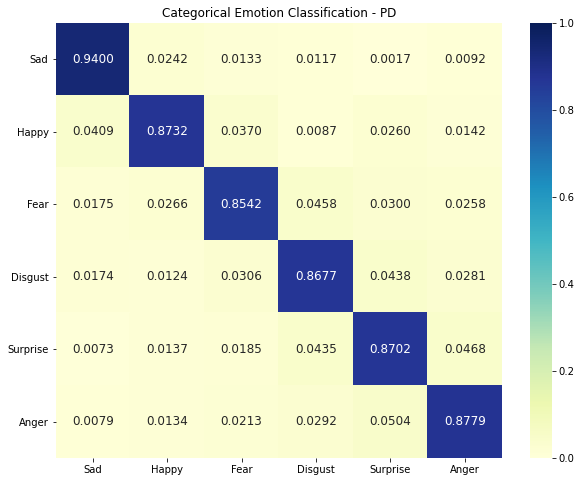

Mean and std of F1 MACRO is 0.8803 +- 0.0948
Mean and std of F1 WEIGHTED is 0.8802 +- 0.0948
Mean and std of accuracy is 0.8804 +- 0.0948


"\nsio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,\n                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat, 'conf_mat_list':cm_list,\n                       'best_params':best_params, 'experiment':experiment,'nb_filters':nb_filters,\n                       'kernel_size':kernel_size, 'pool_size':pool_size, 'stride_size':stride_size,'padding':padding,\n                       'weight_decay':weight_decay, 'dense_layer_neuron_num':dense_layer_neuron_num,'epochs':epochs,\n                      'train_loss':train_loss, 'train_accuracy':train_accuracy, 'val_loss':val_loss,\n                       'val_accuracy':val_accuracy})\n"

In [6]:
#conf_mat = np.zeros((2,2))
foldNum = 10
conf_mat = np.zeros((6,6))
f = 0
cm_list = []
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []
f1_MacroNet = np.zeros([foldNum,]) 
f1_weightedNet = np.zeros([foldNum,])
precisionNet = np.zeros([foldNum,])
recallNet = np.zeros([foldNum,])
accNet = np.zeros([foldNum,])

#channels = features.shape[2] # number of channels 14
kfold = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)

for train, test in kfold.split(features, labels):
    trainingFeatures = features[train,:,:, :]
    testFeatures = features[test,:,:, :]
    train_shape = trainingFeatures.shape
    test_shape = testFeatures.shape
    tf.keras.backend.clear_session()#to clear any previosuly obtiained models
    estimator.summary()
    dummy = estimator.fit(trainingFeatures, labels_categorical[train,:], batch_size=32, 
                  epochs=epochs, verbose=2, validation_split=0.1)
    
    predicted_labelsNet = estimator.predict_classes(testFeatures, verbose=0)
    predicted_probsNet = estimator.predict_proba(testFeatures,batch_size=1,verbose=0)
    #cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[0,1])
    cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[1,2,3,4,5,0])
    cm = cm/cm.sum(axis=1, keepdims=True)
    #conf_mat = conf_mat+cm
    cm_list.append(cm)

    precisionNet[f] = precision_score(labels[test,], predicted_labelsNet, average='macro')
    recallNet[f] = recall_score(labels[test,], predicted_labelsNet, average='macro')
    f1_MacroNet[f] = f1_score(labels[test,], predicted_labelsNet, average='macro')
    f1_weightedNet[f] = f1_score(labels[test,], predicted_labelsNet, average='weighted')
    accNet[f] = accuracy_score(labels[test,], predicted_labelsNet)
    print(experiment + '_CNN: Fold %d : f1_macroscore: %.4f' % (f + 1, f1_MacroNet[f]))
    print(experiment + '_CNN: Fold %d : f1_weightedscore: %.4f' % (f + 1, f1_weightedNet[f]))
    print(experiment + '_CNN: Fold %d : acc: %.4f' % (f + 1, accNet[f]))
    f += 1
    train_loss.append(dummy.history['loss'])
    val_loss.append(dummy.history['val_loss'])
    train_accuracy.append(dummy.history['accuracy'])
    val_accuracy.append(dummy.history['val_accuracy'])

#xc = range(1,epochs+1)
tr_loss_df = pd.DataFrame(train_loss)
tr_acc_df = pd.DataFrame(train_accuracy)
val_loss_df = pd.DataFrame(val_loss)
val_acc_df = pd.DataFrame(val_accuracy)

train_loss_mlist = tr_loss_df.mean(axis=0).to_numpy()
train_loss_slist = tr_loss_df.std(axis=0).to_numpy()
train_acc_mlist = tr_acc_df.mean(axis=0).to_numpy() 
train_acc_slist = tr_acc_df.std(axis=0).to_numpy() 
val_loss_mlist = val_loss_df.mean(axis=0).to_numpy() 
val_loss_slist = val_loss_df.std(axis=0).to_numpy() 
val_acc_mlist = val_acc_df.mean(axis=0).to_numpy()
val_acc_slist = val_acc_df.std(axis=0).to_numpy()

plt.figure()
plt.subplot(1, 2, 1)

y1 = train_loss_mlist
e1 = train_loss_slist
y2 = val_loss_mlist
e2 = val_loss_slist
x1 = range(1, len(train_loss_mlist)+1)
a1 = plt.plot(x1, y1, color='#089FFF', label='Training Loss')
plt.fill_between(x1, y1-e1, y1+e1, alpha=0.3, facecolor='#089FFF', linewidth=4)
a2 = plt.plot(x1, y2, color='#cc9106', label='Validation Loss')
plt.fill_between(x1, y2-e2, y2+e2, alpha=0.3, facecolor='#cc9106', linewidth=4)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
y3 = train_acc_mlist
e3 = train_acc_slist
y4 = val_acc_mlist
e4 = val_acc_slist
x2 = range(1, len(train_acc_mlist)+1)
a1 = plt.plot(x2, y3, color='#089FFF', label='Training Accuracy')
plt.fill_between(x2, y3-e3, y3+e3, alpha=0.3, facecolor='#089FFF', linewidth=4)
a2 = plt.plot(x2, y4, color='#cc9106', label='Validation Accuracy')
plt.fill_between(x2, y4-e4, y4+e4, alpha=0.3, facecolor='#cc9106', linewidth=4)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.tight_layout()
#plt.savefig(filename[:-4]+'_loss_acc_curve'+'.png')
plt.show()

conf_mat = np.mean(cm_list, axis=0)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap='YlGnBu', annot = True, fmt='.4f', vmin=0, vmax=1, annot_kws = {'fontsize':12})
#ax.set_yticklabels(['LA', 'HA'], rotation = 0)
#ax.set_xticklabels(['LA', 'HA'], rotation = 0)
ax.set_yticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
ax.set_xticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)

ax.set_title(plot_title)
#ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

print('Mean and std of F1 MACRO is %.4f +- %.4f' % (np.mean(f1_MacroNet), np.std(f1_MacroNet)))
print('Mean and std of F1 WEIGHTED is %.4f +- %.4f' % (np.mean(f1_weightedNet), np.std(f1_weightedNet)))
print('Mean and std of accuracy is %.4f +- %.4f' % (np.mean(accNet), np.std(accNet)))

# Save results
'''
sio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,
                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat, 'conf_mat_list':cm_list,
                       'best_params':best_params, 'experiment':experiment,'nb_filters':nb_filters,
                       'kernel_size':kernel_size, 'pool_size':pool_size, 'stride_size':stride_size,'padding':padding,
                       'weight_decay':weight_decay, 'dense_layer_neuron_num':dense_layer_neuron_num,'epochs':epochs,
                      'train_loss':train_loss, 'train_accuracy':train_accuracy, 'val_loss':val_loss,
                       'val_accuracy':val_accuracy})
'''

In [7]:
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

print('Mean and std of F1 MACRO is %.4f +- %.4f' % (np.mean(f1_MacroNet), np.std(f1_MacroNet)))
print('Mean and std of F1 WEIGHTED is %.4f +- %.4f' % (np.mean(f1_weightedNet), np.std(f1_weightedNet)))
print('Mean and std of accuracy is %.4f +- %.4f' % (np.mean(accNet), np.std(accNet)))

# Save results
sio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,
                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat, 'conf_mat_list':cm_list,
                       'best_params':best_params, 'experiment':experiment,'nb_filters':nb_filters,
                       'kernel_size':kernel_size, 'pool_size':pool_size, 'stride_size':stride_size,'padding':padding,
                       'weight_decay':weight_decay, 'dense_layer_neuron_num':dense_layer_neuron_num,'epochs':epochs,
                      'train_loss':train_loss, 'train_accuracy':train_accuracy, 'val_loss':val_loss,
                       'val_accuracy':val_accuracy})

Mean and std of F1 MACRO is 0.8803 +- 0.0948
Mean and std of F1 WEIGHTED is 0.8802 +- 0.0948
Mean and std of accuracy is 0.8804 +- 0.0948
